# Exploratory Data Analysis

This notebook contains the first part of the second assignment.

Here we will explore the data from the file credit.csv that we will build the model from.

I split EDA and Modeling for reading comfort.

---

## Summary of findings

---

#### Data Structure

- Dataset has 1,000 observations and 21 variables + target
- Target has 70/30 class balance -> 30% default rate (very high)
- 6 variables with missing data, include 3 with more than 30%
- 10 numerical features - 11 non-numerical


#### Feature specificities

- *telephone* feature contains local nigerian phone numbers only. We can remove 234 extension and maybe engineer it to extract first digit(s). 
- 2 features can be converted to numerical (*employment length*, *residence_history*)



#### Average Profile

- 33 years single old male with no dependent
- ~2K€ loan for ~20 months duration for electronics or car purchase
- Foreign skilled employee with 4 years of residence and 3 years of employment history

#### Relation to target

- cases with missing 'checking_balance' have very low default risk.
- risk is increasing with loan duration (longer exposure)
- risk is decreasing with age and wealth (savings / property)
- risk is higher for women
- risk is lower for non-foreigner
- risk is higher for divorced people
- risk is lower for smart investment purposes like retraining or buying a used car vs new car
- risk is decreasing with employment length
- presence of guarantor is a mitigant but co-applicant is a factor of risk
- risk is increasing with installment rate
- having other credits is actually a good sign up until 3 credits

#### Unexpected findings

- 96% of applicants are foreigners
- Missing 'checking_balance' is a very positive sign
- Fully repaid credit history is a very negative sign while critical credit history is a very positive sign (looks like messed up categories)

---

## Loading Data

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import feature_engine

In [2]:
credit = pd.read_csv('credit.csv', index_col = 0)
credit.head().T

,0,1,2,3,4
checking_balance,-43.0,75.0,NaN,-32.0,-23.0
months_loan_duration,6,48,12,42,24
credit_history,critical,repaid,critical,repaid,delayed
purpose,radio/tv,radio/tv,education,furniture,car (new)
amount,1169,5951,2096,7882,4870
savings_balance,NaN,89.0,24.0,9.0,43.0
employment_length,13 years,2 years,5 years,5 years,3 years
installment_rate,4,2,2,2,3
personal_status,single,NaN,single,single,single
other_debtors,none,none,none,guarantor,none


----

## Exploratory Data Analysis

---

In [3]:
credit.shape

(1000, 22)

Dataset of 1,000 observations and 22 variables including target

In [4]:
credit.dtypes.value_counts()

object     12
int64       7
float64     3
dtype: int64

Dataset has 10 numerical variables and 12 non-numerical variables

In [5]:
credit.isnull().sum().sort_values(ascending = False) / 10 

telephone               59.6
checking_balance        39.4
personal_status         31.0
savings_balance         18.3
residence_history       13.0
employment_length        6.2
installment_plan         0.0
job                      0.0
foreign_worker           0.0
dependents               0.0
default                  0.0
existing_credits         0.0
housing                  0.0
property                 0.0
age                      0.0
months_loan_duration     0.0
other_debtors            0.0
installment_rate         0.0
amount                   0.0
purpose                  0.0
credit_history           0.0
gender                   0.0
dtype: float64

6 variables with missing data / telephone with more than 60%. We will decide later on how to handle these.

### Target

---

In [6]:
credit.default.value_counts()

0    700
1    300
Name: default, dtype: int64

30% of cases are in default. This is a pretty high default rate.

Still the dataset is slightly imbalanced and we might have to work on that.

### Numerical features

---

In [7]:
num_features = credit._get_numeric_data()
print(num_features.columns, len(num_features.columns))

Index(['checking_balance', 'months_loan_duration', 'amount', 'savings_balance',
       'installment_rate', 'age', 'existing_credits', 'default', 'dependents',
       'telephone'],
      dtype='object') 10


Let's separate continuous features and discrete features

In [8]:
continuous_features = [var for var in num_features.columns if credit[var].nunique() > 10]
discrete_features = [var for var in num_features.columns if var not in continuous_features]
print('continuous features: ', continuous_features)
print()
print('discrete features: ', discrete_features)

continuous features:  ['checking_balance', 'months_loan_duration', 'amount', 'savings_balance', 'age', 'telephone']

discrete features:  ['installment_rate', 'existing_credits', 'default', 'dependents']


In [9]:
def num_feature_analysis(data, var, var_type = 'continuous', bins = 5):
    
    df = data.copy()
      
    # summary statistics
    print('Summary statistics: ')
    print(df[var].describe())
    print()  
    
    # missing share
    missing_share = df[var].isnull().sum() / 10
    print(f"Percentage of missing data: {missing_share}%")
    print()
    
    # default rate on missing vs non-missing
    if missing_share > 0:

        df['is_missing'] = df[var].isnull().astype(int)
        miss_rate = df.groupby('is_missing')['default'].mean()
        print("Default rate - missing data: ", miss_rate[1].round(2) )
        print()
        print("Default rate - non-missing: ", miss_rate[0].round(2) )
        print()
    
    
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 3))

    if var_type == 'continuous':

        # Plot histogram
        axs[0].set_title('Distribution' , fontsize = 11, loc = 'left')
        sns.histplot(data=df, x=var, ax = axs[0], bins = 15)
        
        # Plot Box-Plot per default class    
        axs[1].set_title('Box-plot per default class', fontsize = 11, loc = 'left')
        sns.boxplot(y = df['default'].astype('category'), x = var, data=df, ax = axs[1])
    
        # average default rate per bins
        axs[2].set_title('Default rate per bins', fontsize = 11, loc = 'left')
        df[var + '_bins'] = pd.qcut(df[var], q=bins, precision = 0)
        sns.barplot(data=df, x=var + '_bins', y='default', errorbar=None, ax = axs[2])
        # axs[1,0].xticks(rotation='horizontal')
        
    else:
        
        print(f"Percentage of each discrete values: ")
        print((df[var].value_counts(normalize=True)*100).round(1))
        print()
        
        # Count plot
        axs[0].set_title('Distribution - in %', fontsize = 11, loc = 'left')
        #sns.countplot(data=df, y=var, ax = axs[0])
        sns.barplot(x=var, y=var, data=df, estimator=lambda x: len(x) / len(df) * 100, ax = axs[0])
        
        # Count plot per default class  
        axs[1].set_title('Distribution per default class - in %', fontsize = 11, loc = 'left')
        sns.barplot(x=var, y=var, data=df, hue = 'default', estimator=lambda x: len(x) / len(df) * 100, ax = axs[1])
        # sns.countplot(data=df, x=var, hue = 'default', ax = axs[1] )
        
        # average default rate per bins
        axs[2].set_title('Default rate per value', fontsize = 11, loc = 'left')
        sns.barplot(data=df, x=var, y='default', errorbar=None, ax = axs[2])

        
    for ax in axs.flat:
        ax.set(xlabel='', ylabel='')
    fig.tight_layout()

### Continuous features




#### Checking Balance

Status of the existing checking account (Euros).

Summary statistics: 
count    606.000000
mean      97.245875
std      206.923583
min      -50.000000
25%      -23.000000
50%       24.000000
75%      131.750000
max      999.000000
Name: checking_balance, dtype: float64

Percentage of missing data: 39.4%

Default rate - missing data:  0.12

Default rate - non-missing:  0.42



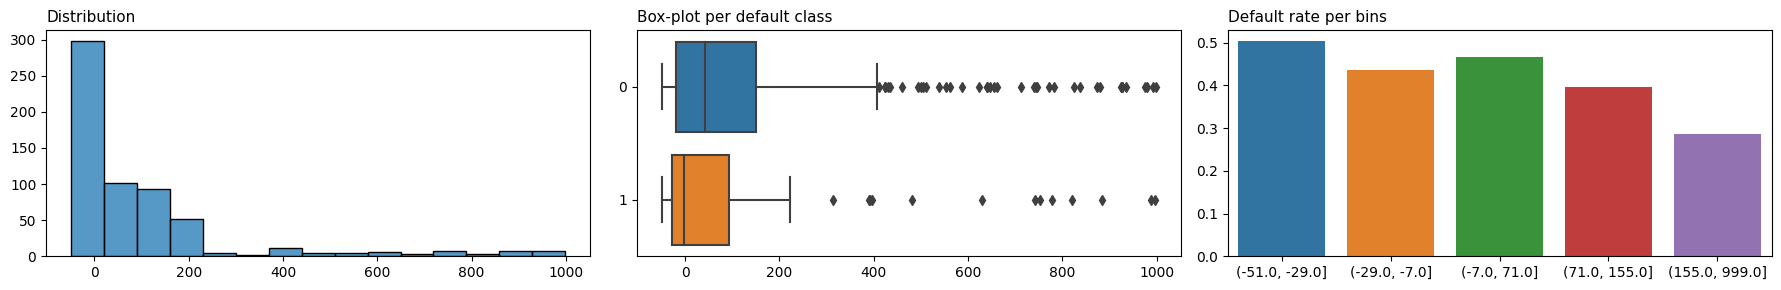

In [10]:
num_feature_analysis(credit, 'checking_balance')

- Distribution - checking Balance ranges from -50€ to 999€ (It is kind of weird that the max is 999), mean is 97€ (far from median = 24€). 

- Risk trend - risk is decreasing with balance

- Missing data - 40% of missing data - cases with missing values have a very low default risk

---

#### Loan duration

Duration of loan in months

Summary statistics: 
count    1000.000000
mean       20.903000
std        12.058814
min         4.000000
25%        12.000000
50%        18.000000
75%        24.000000
max        72.000000
Name: months_loan_duration, dtype: float64

Percentage of missing data: 0.0%



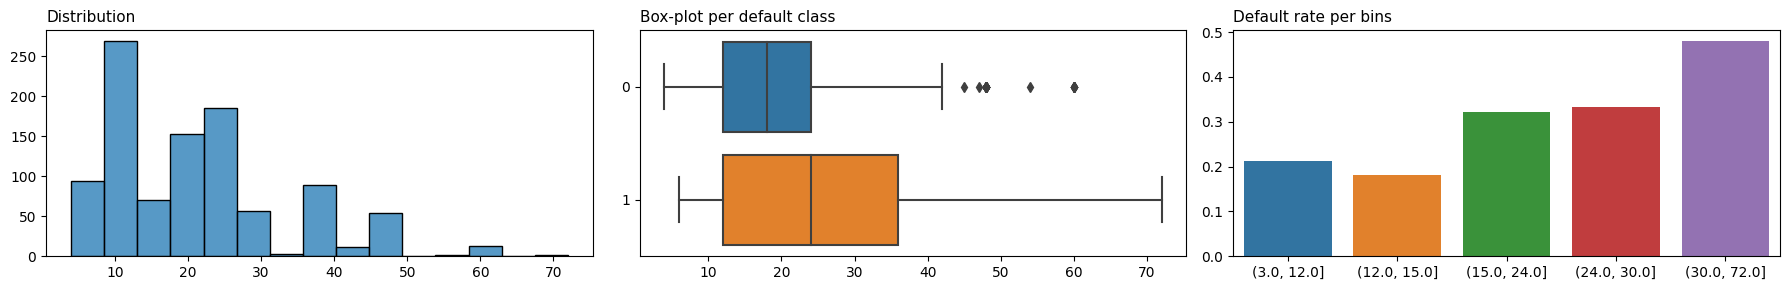

In [11]:
num_feature_analysis(credit, 'months_loan_duration')

- Distribution - duration ranges from 4 months up to 72 months (6 years) and average is 20 months (close to median = 18).

- Risk trend - risk of default is clearly increasing with duration which makes sense (longer exposure to risk), although very short durations show slightly higher default rate than duration between 12 to 15 months.

- Missing data : None

---

#### Amount

No description provided - we can assume it is the credit amount

Summary statistics: 
count     1000.000000
mean      3271.258000
std       2822.736876
min        250.000000
25%       1365.500000
50%       2319.500000
75%       3972.250000
max      18424.000000
Name: amount, dtype: float64

Percentage of missing data: 0.0%



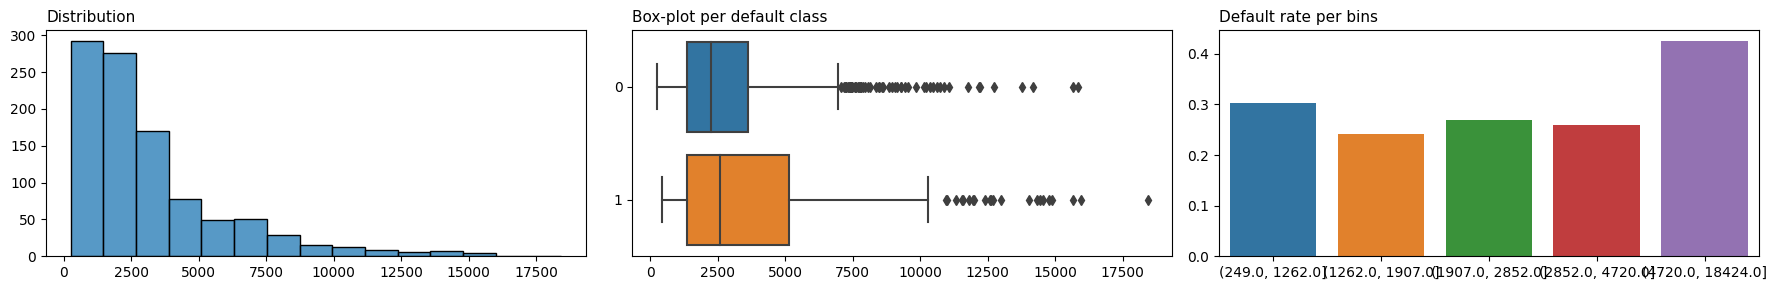

In [12]:
num_feature_analysis(credit, 'amount')

- Distribution - amount ranges from 250€ to 18,425€ (we assume here amount is in €), mean is 3.3K€ (not so close to median = 2.3K)

- Risk trend: risk of default seems to be higher on very high amounts. Risk is also higher on small amounts vs medium amounts.

- Missing Data: None

---

#### Savings Balance

Savings account/bonds (Euros) 

Summary statistics: 
count      817.000000
mean       781.570379
std       3016.983785
min          0.000000
25%         31.000000
50%         64.000000
75%        128.000000
max      19972.000000
Name: savings_balance, dtype: float64

Percentage of missing data: 18.3%

Default rate - missing data:  0.17

Default rate - non-missing:  0.33



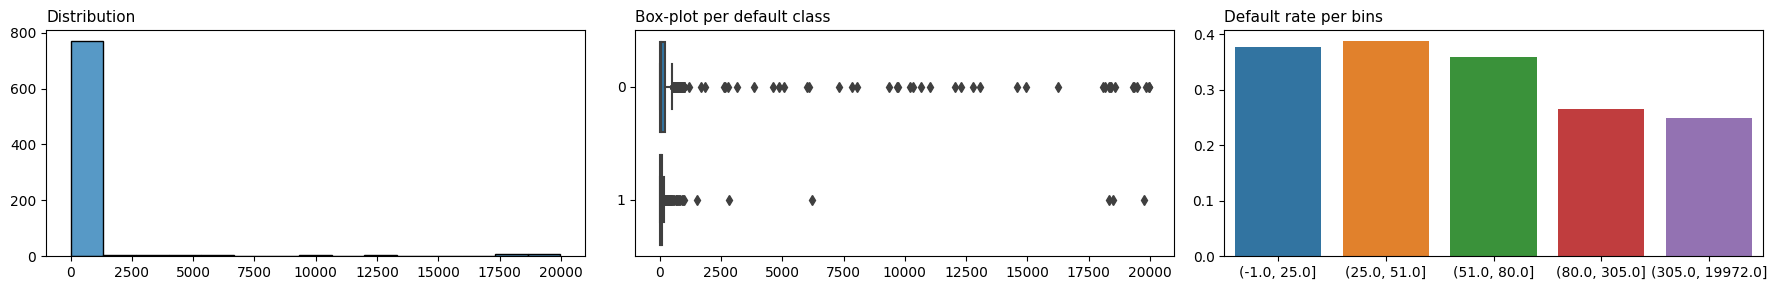

In [13]:
num_feature_analysis(credit, 'savings_balance')

- Distribution - Savings balance ranges from 0 up to 20K€ with a mean of 781€ and a median of 64€. There are strong outliers. We may have to deal with this either through capping or discretization. 

- Risk trend - Risk is logically decreasing with increasing savings. 

- Missing Data - 20% of missing data. Cases with missing data have pretty low default rate.

---

#### Age

Summary statistics: 
count    1000.000000
mean       35.546000
std        11.375469
min        19.000000
25%        27.000000
50%        33.000000
75%        42.000000
max        75.000000
Name: age, dtype: float64

Percentage of missing data: 0.0%



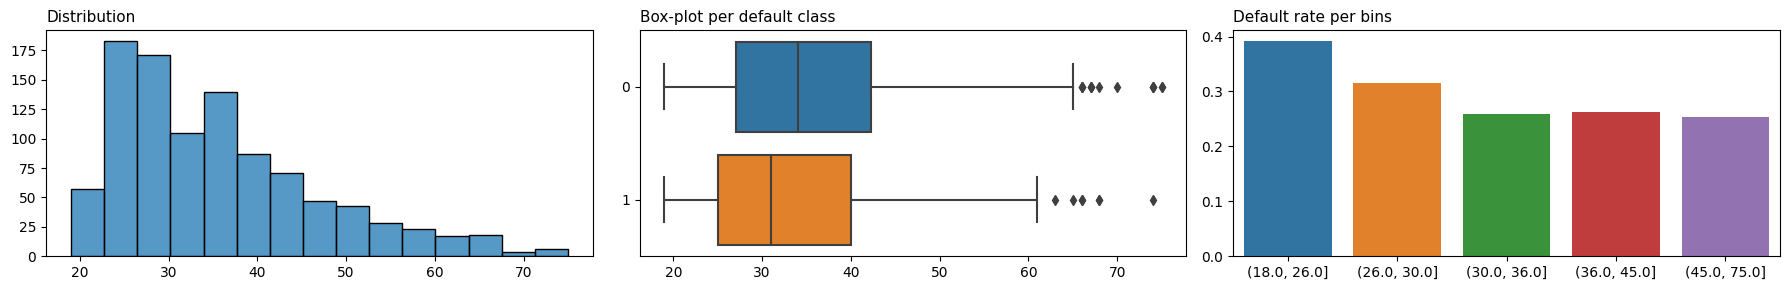

In [14]:
num_feature_analysis(credit, 'age')

- Distribution - ages ranges from 19 up to 75 with mean of 35 and median of 33.

- Risk trend - average default rate is clearly decreasing with age, which makes sense.

- Missing data: None

---

### Discrete features

---

#### Telephone

Phone number

In [15]:
credit['telephone'].astype(str).str[:3].value_counts()

nan    596
234    404
Name: telephone, dtype: int64

Provided phone numbers are all nigerian phone numbers.

- Telephone numbers in Nigeria use a combination of area codes and personal numbers. 

- Area codes are one digit (Lagos - 1, Ibadan - 2  and Abuja - 9 ) or two digits. 

- Local phone numbers contain between five and seven digits.

- Mobile phone numbers start with 070, 080 or 081, 090 or 091 and are followed by eight digits.

- Let's remove extension and try to extract first numbers

In [16]:
credit['telephone'] = credit.loc[credit['telephone'].notnull(), 'telephone'].astype(str).str[3:]
credit['telephone'].head()

0    9339647.0
1          NaN
2          NaN
3          NaN
4          NaN
Name: telephone, dtype: object

In [17]:
credit['telephone'].str.len().value_counts()

9.0    404
Name: telephone, dtype: int64

Numbers are all 7 digits (local phone numbers). Let's extract first digit.

Summary statistics: 
count    404.000000
mean       4.418317
std        2.968112
min        0.000000
25%        2.000000
50%        4.000000
75%        7.000000
max        9.000000
Name: telephone, dtype: float64

Percentage of missing data: 59.6%

Default rate - missing data:  0.31

Default rate - non-missing:  0.28

Percentage of each discrete values: 
8.0    13.9
1.0    12.9
0.0    11.1
4.0    10.4
5.0     9.2
6.0     9.2
9.0     8.9
2.0     8.7
3.0     8.2
7.0     7.7
Name: telephone, dtype: float64



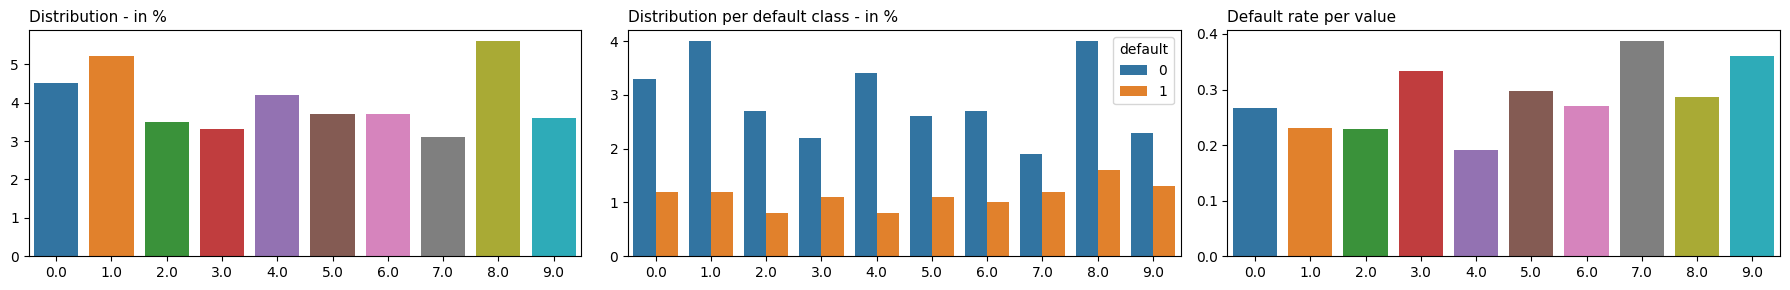

In [18]:
test = credit.copy()
test['telephone'] = test.loc[test['telephone'].notnull(), 'telephone'].str[0].astype(float)
num_feature_analysis(test, 'telephone', var_type = 'discrete')

- Distribution - First digit are quite uniformly distributed

- Risk trend - Phone numbers starting with 4 he significantly lower risk while numbers starting with 3,7 or 9 are above average

- Missing data - Phone number is missing for 60% of the applicant. Cases with missing phone number show a slightly higher risk of default.

Summary statistics: 
count    404.000000
mean      48.631188
std       30.067503
min        0.000000
25%       22.000000
50%       47.500000
75%       77.000000
max       99.000000
Name: telephone, dtype: float64

Percentage of missing data: 59.6%

Default rate - missing data:  0.31

Default rate - non-missing:  0.28

Percentage of each discrete values: 
88.0    2.2
11.0    2.2
89.0    2.0
86.0    2.0
51.0    2.0
       ... 
42.0    0.2
20.0    0.2
73.0    0.2
98.0    0.2
50.0    0.2
Name: telephone, Length: 100, dtype: float64



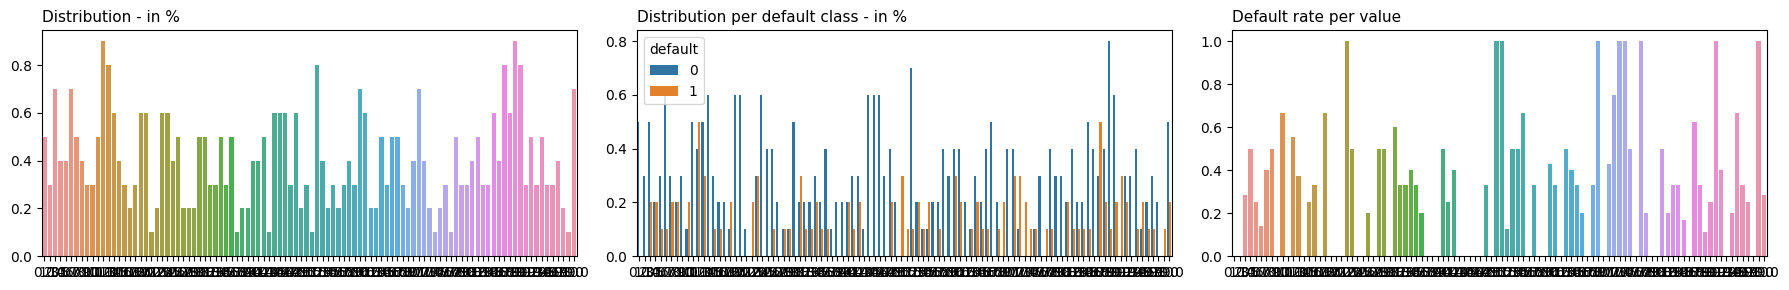

In [19]:
test = credit.copy()
test['telephone'] = test.loc[test['telephone'].notnull(), 'telephone'].str[:2].astype(float)
num_feature_analysis(test, 'telephone', var_type = 'discrete')

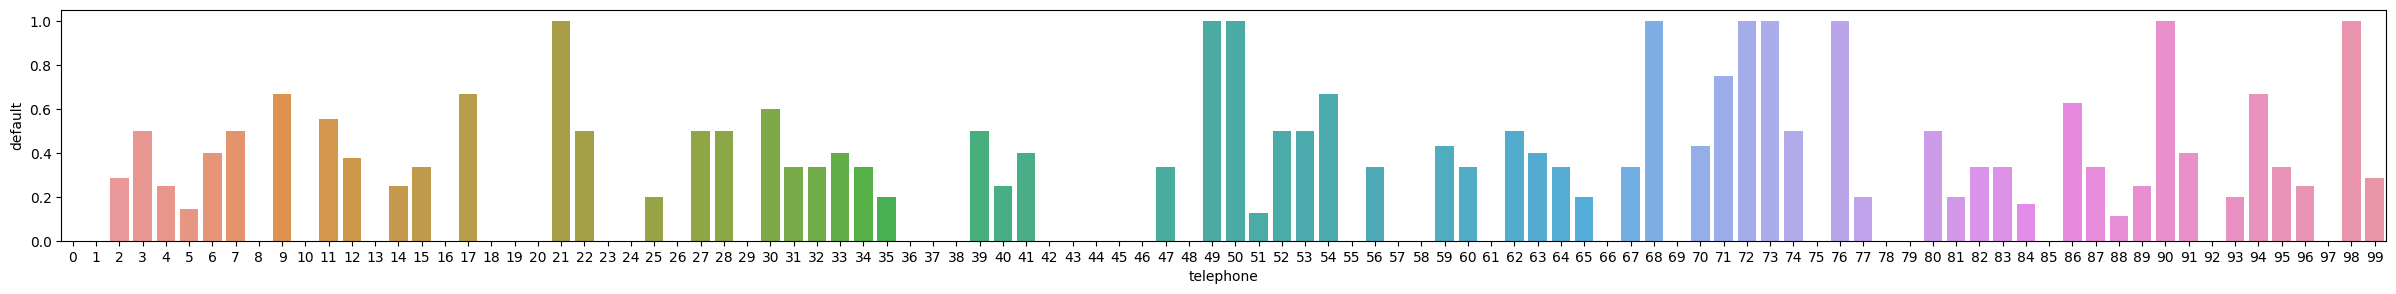

In [20]:
plt.figure(figsize=(30,3))
sns.barplot(data=test, x='telephone', y='default', errorbar=None)
from matplotlib.ticker import StrMethodFormatter
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places

- There are strong discrepancies of risk but classes have very low population. We may try modeling with this variable but we'll probably stick with one digit.

---

#### Installment Rate

Installment rate in percentage of disposable income

Summary statistics: 
count    1000.000000
mean        2.973000
std         1.118715
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: installment_rate, dtype: float64

Percentage of missing data: 0.0%

Percentage of each discrete values: 
4    47.6
2    23.1
3    15.7
1    13.6
Name: installment_rate, dtype: float64



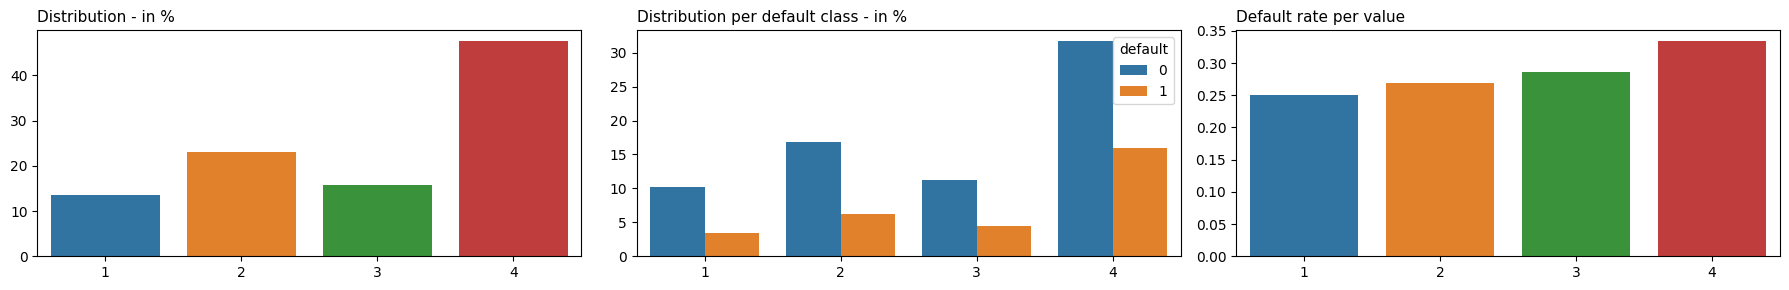

In [21]:
num_feature_analysis(credit, 'installment_rate', var_type = 'discrete')

- Distribution - Installment rate is a discrete variable with 4 possibles values from 1 to 4. Almost half of the cases are of class 4.

- Risk trend - We may assume that each numbers refers to an interval of rate (e.g. very low, low, high, very high) which would be consistent with the increasing default rate with increasing value.

- Missing data - None 

---

### Existing Credits

Number of existing credits at this bank.

Summary statistics: 
count    1000.000000
mean        1.407000
std         0.577654
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: existing_credits, dtype: float64

Percentage of missing data: 0.0%

Percentage of each discrete values: 
1    63.3
2    33.3
3     2.8
4     0.6
Name: existing_credits, dtype: float64



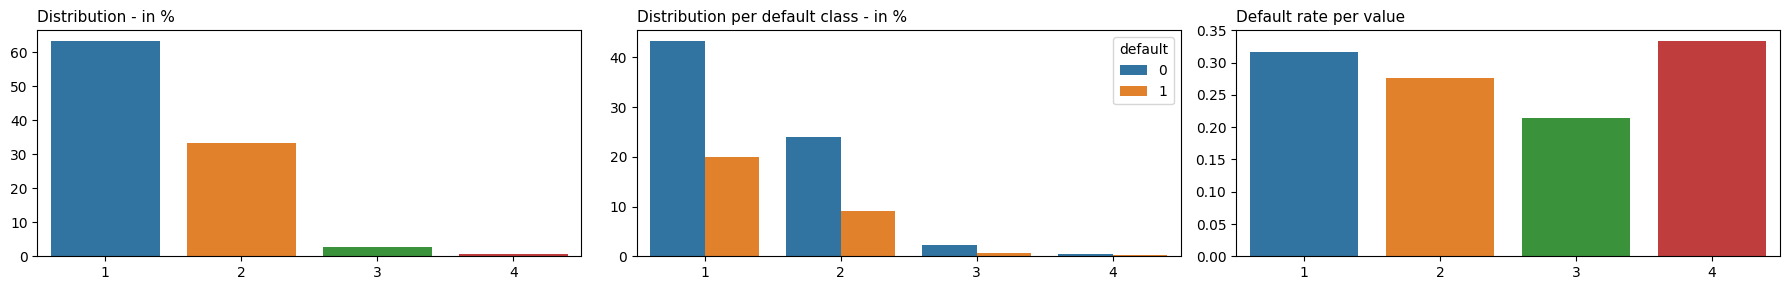

In [22]:
num_feature_analysis(credit, 'existing_credits', var_type = 'discrete')

- Distribution - Number of existing credits ranges from 1 to 4. There is 1 existing credit for 63% of cases and 2 or less for 97% of cases.

- Risk trend - Risk is decreasing up to 3 credits then it jump at 4. Having more than one credit can be a positive sign unless it is too many of them.

- Missing data - None

---

### Dependents

Number of people being liable to provide maintenance for

Summary statistics: 
count    1000.000000
mean        1.155000
std         0.362086
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: dependents, dtype: float64

Percentage of missing data: 0.0%

Percentage of each discrete values: 
1    84.5
2    15.5
Name: dependents, dtype: float64



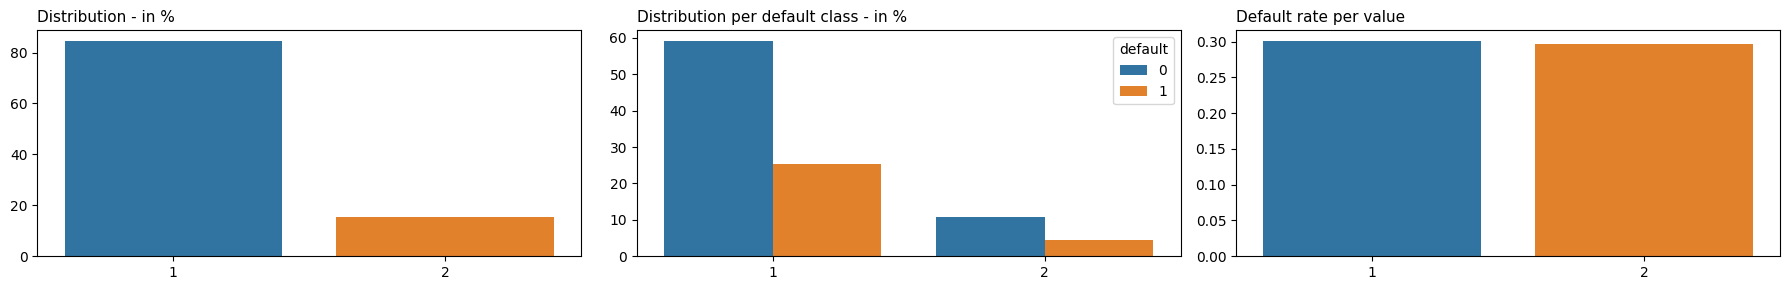

In [23]:
num_feature_analysis(credit, 'dependents', var_type = 'discrete')

- Distribution - There are only two values 1 and 2 which is kind of strange. Maybe these are classes.

- Risk trend - There is almost no difference between both values in terms of default rate.

- Missing data - None

---

### Correlation matrix for numerical features 

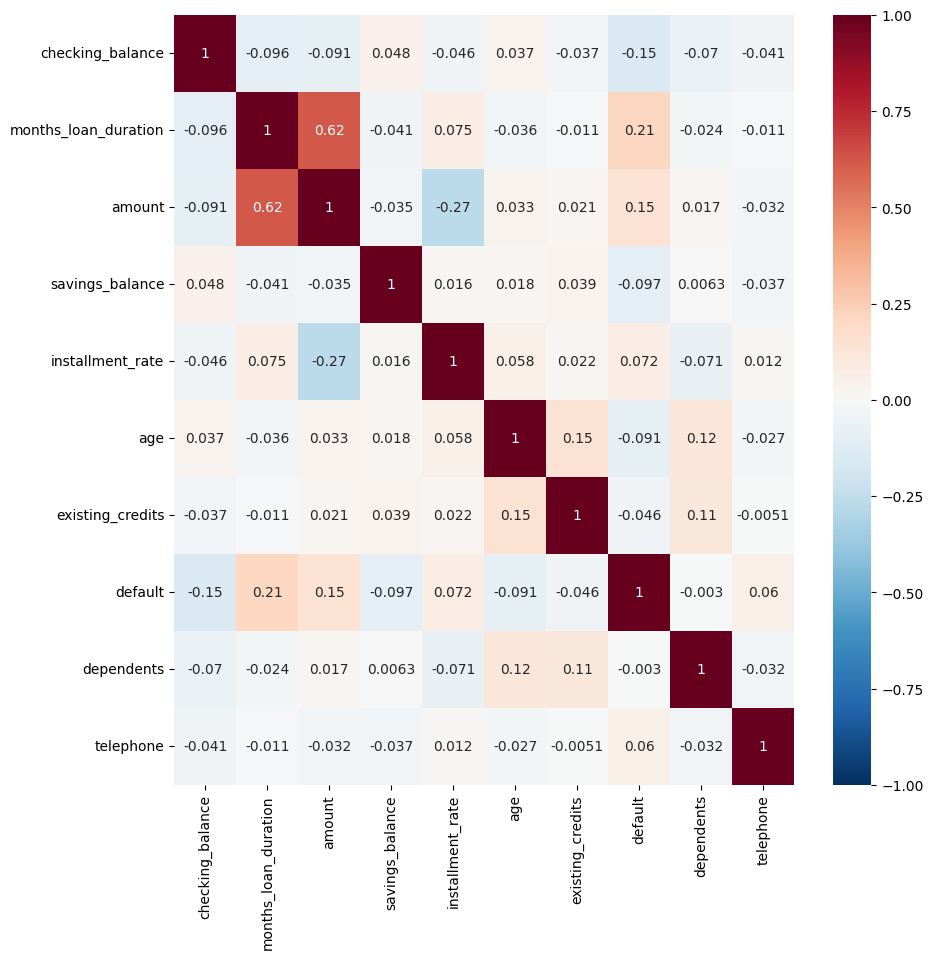

In [24]:
corr = num_features.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap='RdBu_r', annot=True, vmax=1, vmin=-1)
plt.show()

- We can notice a strong correlation between the amount and the loand duration which is completely normal. Higher amounts usually imply longer duration.

- There is a 0.27 negative correlation between the amount and the installment rate, which is not necessarily intuitive. We could assume that higher amounts are granted to persons with higher income for whom installments are less heavy.

---

### Categorical Features

In [26]:
cat_features = credit.select_dtypes(include=['object']).columns.tolist()
cat_features

['credit_history',
 'purpose',
 'employment_length',
 'personal_status',
 'other_debtors',
 'residence_history',
 'property',
 'installment_plan',
 'housing',
 'telephone',
 'foreign_worker',
 'job',
 'gender']

In [27]:
def cat_feature_analysis(data, var):
    
    df = data.copy()
       
    # summary statistics
    print('Summary statistics: ')
    print(df[var].describe())
    print()  
    
    # missing share
    missing_share = df[var].isnull().sum() / 10
    print(f"Percentage of missing data: {missing_share}%")
    print()
    
    # default rate on missing vs non-missing
    if missing_share > 0:

        df['is_missing'] = df[var].isnull().astype(int)
        miss_rate = df.groupby('is_missing')['default'].mean()
        print("Default rate - missing data: ", miss_rate[1].round(2) )
        print()
        print("Default rate - non-missing: ", miss_rate[0].round(2) )
        print()
        
    print(f"Percentage of each discrete values: ")
    df.loc[df[var].isnull(), var] = 'missing'
    print((df[var].value_counts(normalize=True)*100).round(1))
    print()
    
    nb_cat = df[var].nunique()
        
    fig, axs = plt.subplots(1, 3, figsize=(18, max(nb_cat/2,4)))
    
    # Count plot
    axs[0].set_title('Distribution - in %', fontsize = 11, loc = 'left')
    sns.countplot(data=df, y=var, ax = axs[0])
        
    # Count plot per default class  
    axs[1].set_title('Distribution per default class - in %', fontsize = 11, loc = 'left')
    sns.countplot(data=df, y=var, hue = 'default', ax = axs[1])
    # axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation = 50)

    # average default rate per bins
    axs[2].set_title('Default rate per value', fontsize = 11, loc = 'left')
    sns.barplot(data=df, y=var, x='default', errorbar=None, ax = axs[2])
    # axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation = 50)

    for ax in axs.flat:
        ax.set(xlabel='', ylabel='')
    fig.tight_layout()

---

#### Credit History

Summary statistics: 
count       1000
unique         5
top       repaid
freq         530
Name: credit_history, dtype: object

Percentage of missing data: 0.0%

Percentage of each discrete values: 
repaid                    53.0
critical                  29.3
delayed                    8.8
fully repaid this bank     4.9
fully repaid               4.0
Name: credit_history, dtype: float64



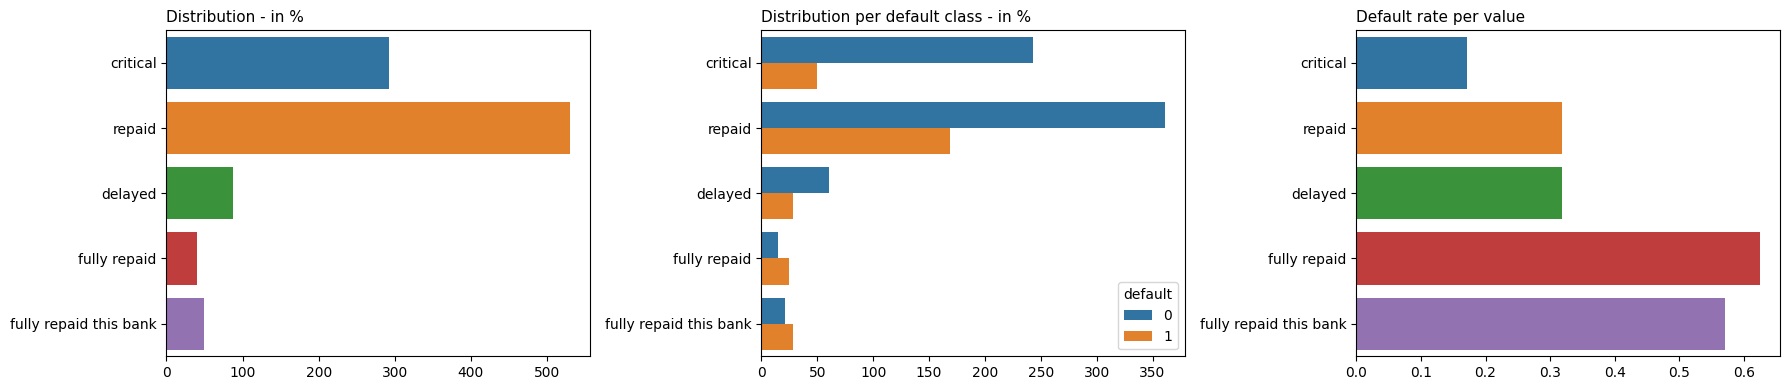

In [28]:
cat_feature_analysis(credit, 'credit_history')

- Distribution - There are 5 distinct categories, two of which seemed to be the same (*fully repaid* and *fully repaid this bank*). So there are in reality 4 classes (*fully repaid*, *repaid*, *critical* and *delayed*). More than half cases are *repaid*, 30% are *critical* and *fully repaid* and *delayed* are around 9% each.

- Risk trend - Default rate is very low for *critical* category and very high for *fully repaid* category which makes very little sense. Might be an alternation of data made for the purpose of the test. In any case, labels don't really matter as long as the segmentation is fine.

- Missing data - None

Summary statistics: 
count       1000
unique         4
top       repaid
freq         530
Name: credit_history, dtype: object

Percentage of missing data: 0.0%

Percentage of each discrete values: 
repaid          53.0
critical        29.3
fully repaid     8.9
delayed          8.8
Name: credit_history, dtype: float64



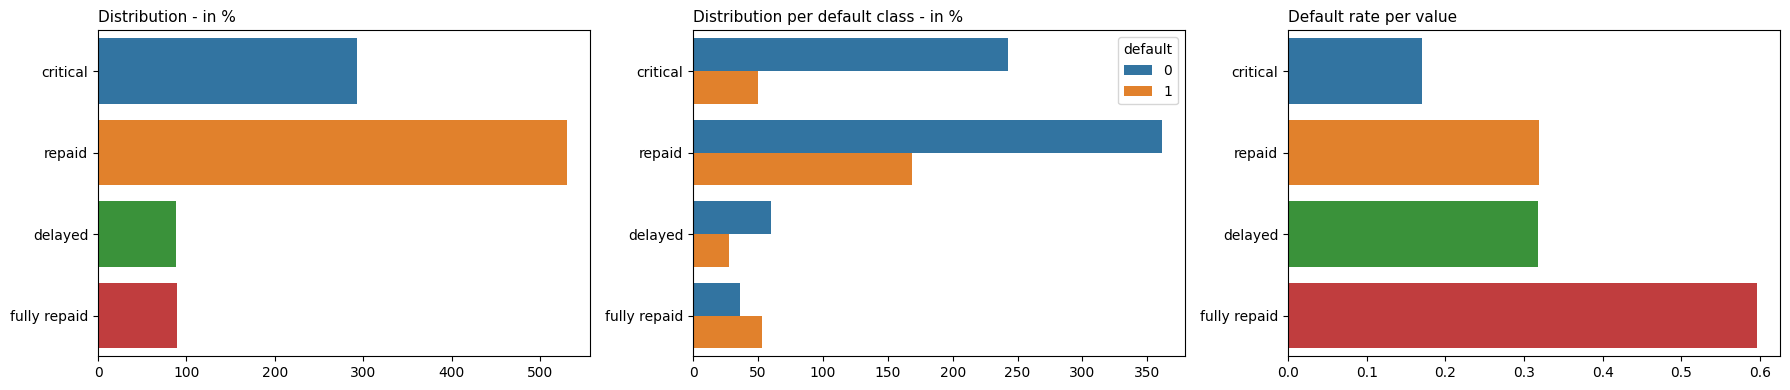

In [29]:
# Let's regroup fully repaid categories 
test = credit.copy()
test['credit_history'] = test['credit_history'].str.replace('fully repaid this bank', 'fully repaid')
cat_feature_analysis(test, 'credit_history')

---

#### Purpose

Purpose of the loan

Summary statistics: 
count         1000
unique          10
top       radio/tv
freq           280
Name: purpose, dtype: object

Percentage of missing data: 0.0%

Percentage of each discrete values: 
radio/tv               28.0
car (new)              23.4
furniture              18.1
car (used)             10.3
business                9.7
education               5.0
repairs                 2.2
domestic appliances     1.2
others                  1.2
retraining              0.9
Name: purpose, dtype: float64



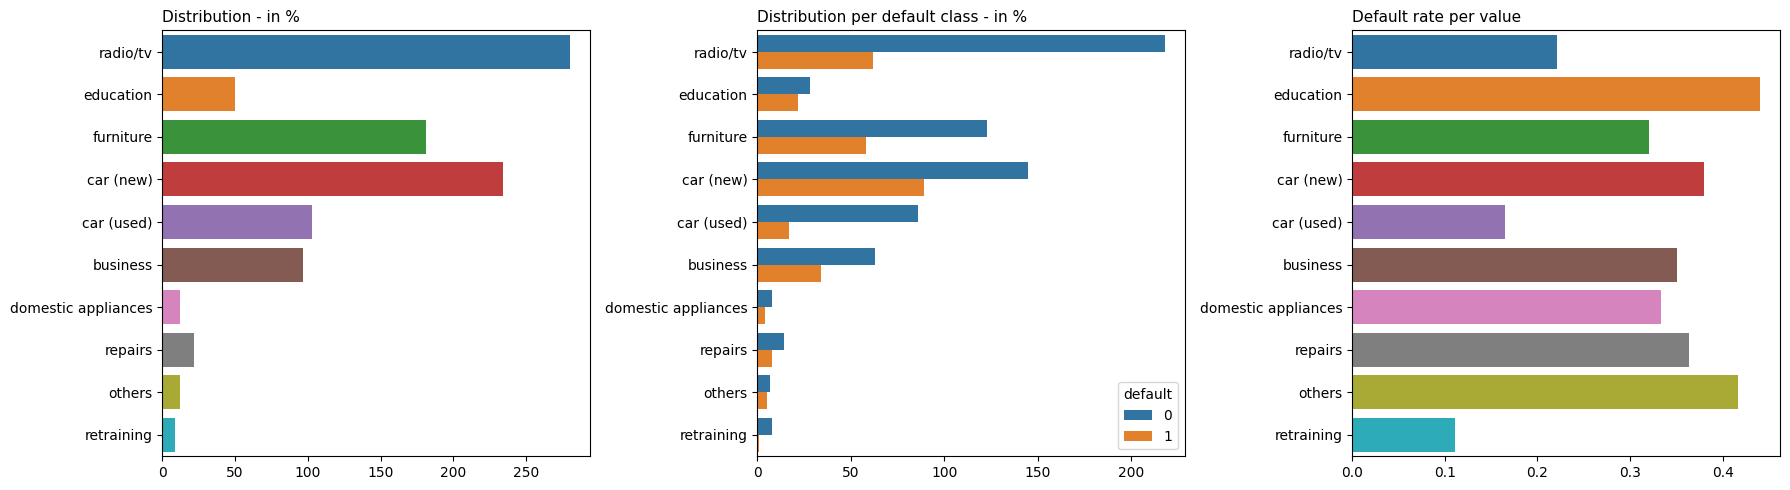

In [30]:
cat_feature_analysis(credit, 'purpose')

- Distribution - There are 10 distinct categories, including an *others* category. The most frequent purpose is the car purchase (34% split between new and old car) followed by radio/tv purchase (28%) and furniture purchase. Business is only 10% and 5% for education. Other categories are minor.

- Risk trend - Loans for retraining are by far the less risky (experienced profiles). Loans for used cars (sign of smart money management) are also less risky. On the other hand, loan for education (young people), purchase of new car and others (unnecessary expenses) are the most risky.  

- Missing data - None

---

#### Employment length

Summary statistics: 
count         938
unique         31
top       1 years
freq          122
Name: employment_length, dtype: object

Percentage of missing data: 6.2%

Default rate - missing data:  0.37

Default rate - non-missing:  0.3

Percentage of each discrete values: 
1 years      12.2
2 years      11.0
3 years      10.7
missing       6.2
7 years       5.7
5 years       4.6
6 years       4.5
4 years       4.4
13 years      2.6
10 years      2.4
19 years      2.4
11 years      2.4
6 months      2.1
9 years       2.0
18 years      2.0
8 years       1.9
12 years      1.9
3 months      1.9
7 months      1.8
15 years      1.7
9 months      1.6
14 years      1.6
4 months      1.5
8 months      1.4
16 years      1.4
10 months     1.3
0 months      1.2
17 years      1.2
11 months     1.2
2 months      1.2
1 months      1.1
5 months      0.9
Name: employment_length, dtype: float64



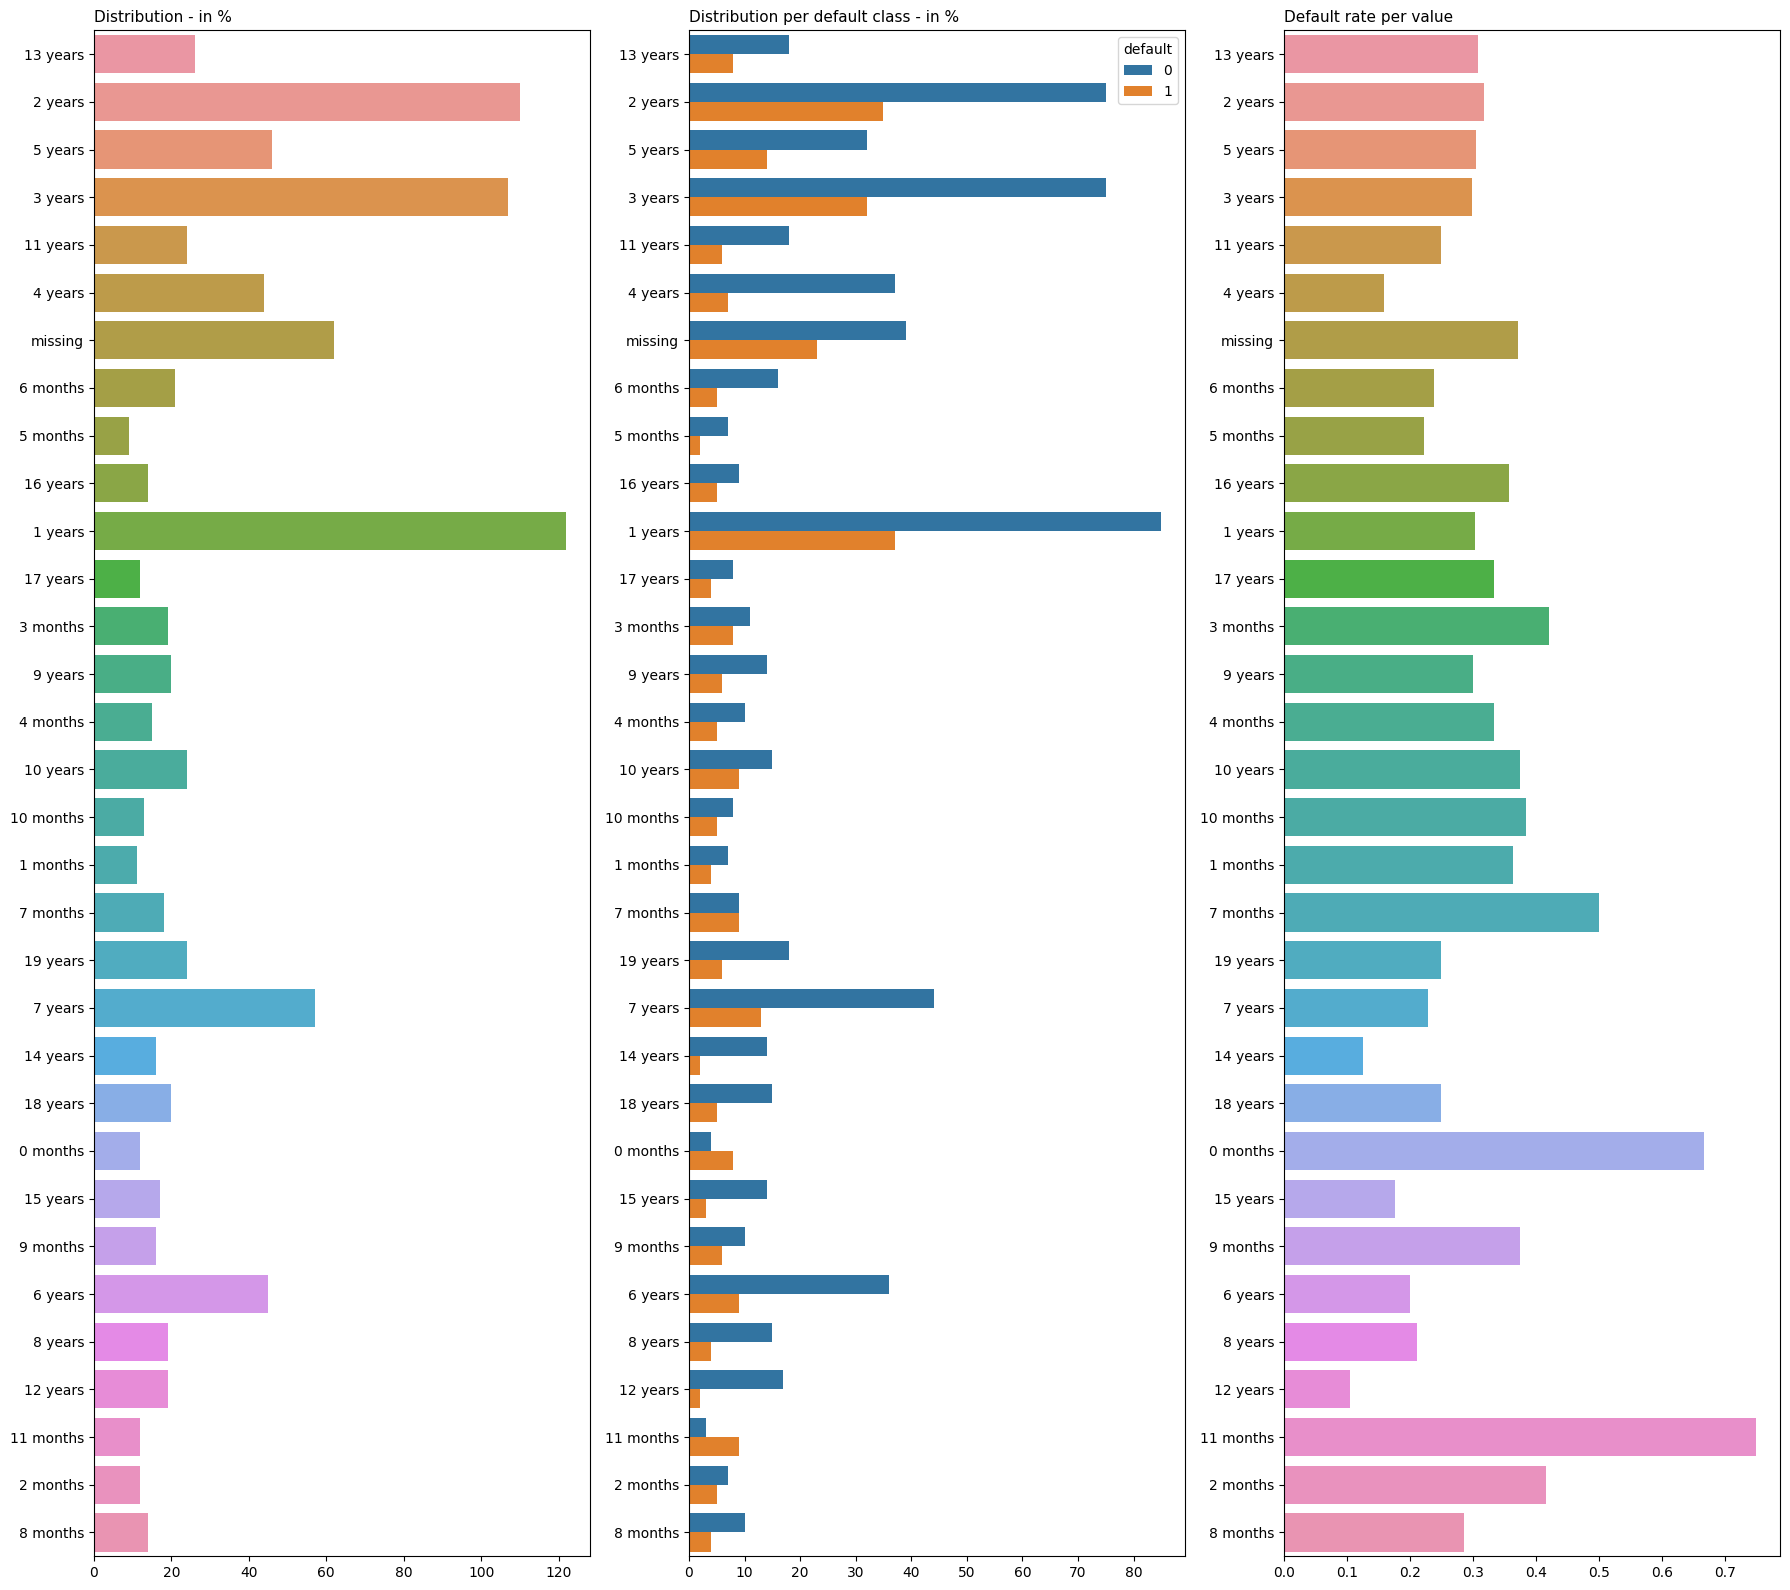

In [31]:
cat_feature_analysis(credit, 'employment_length')

- Distribution - approx. 20% of applicants have less than a year of employment, 30% have 1 to 3 years, 20% from 4 to 7 years and 30% with more than 7 years.

- Risk trend - This variable is hard to interpret as it is. There are too many categories. We either should reduce the categories or turn it into a numerical variables with years or months of employment. We can see that classes with high risk are short employment periods while lowest are long period of unemployment. 

- Missing data - Data is missing for 6% of the cases and there is a slightly higher default rate on missing data.

---

#### Adjusted Employment Length

Let's turn it into numerical variables with number of months of unemployment

Summary statistics: 
count    938.000000
mean      63.244136
std       63.472791
min        0.000000
25%       12.000000
50%       36.000000
75%       93.000000
max      228.000000
Name: employment_length, dtype: float64

Percentage of missing data: 6.2%

Default rate - missing data:  0.37

Default rate - non-missing:  0.3



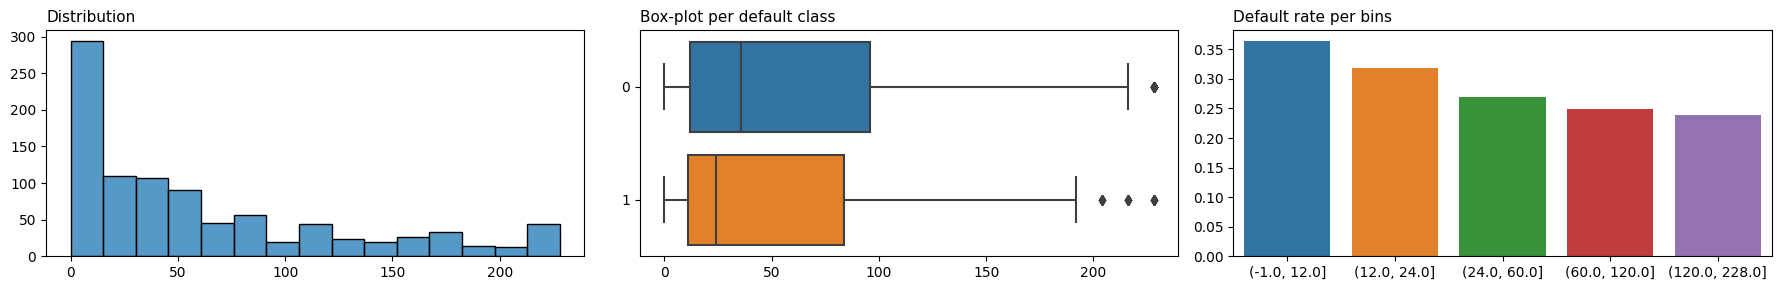

In [32]:
test = test.copy()
test['employment_length'] = test.loc[test['employment_length'].notnull(), 'employment_length'].apply(lambda x : x.replace('months', '').strip() if 'months' in x else int(x.replace('years', '').strip())*12).astype(float)
num_feature_analysis(test, 'employment_length')

---

#### Personal Status

Marital status

Summary statistics: 
count        690
unique         3
top       single
freq         548
Name: personal_status, dtype: object

Percentage of missing data: 31.0%

Default rate - missing data:  0.35

Default rate - non-missing:  0.28

Percentage of each discrete values: 
single      54.8
missing     31.0
married      9.2
divorced     5.0
Name: personal_status, dtype: float64



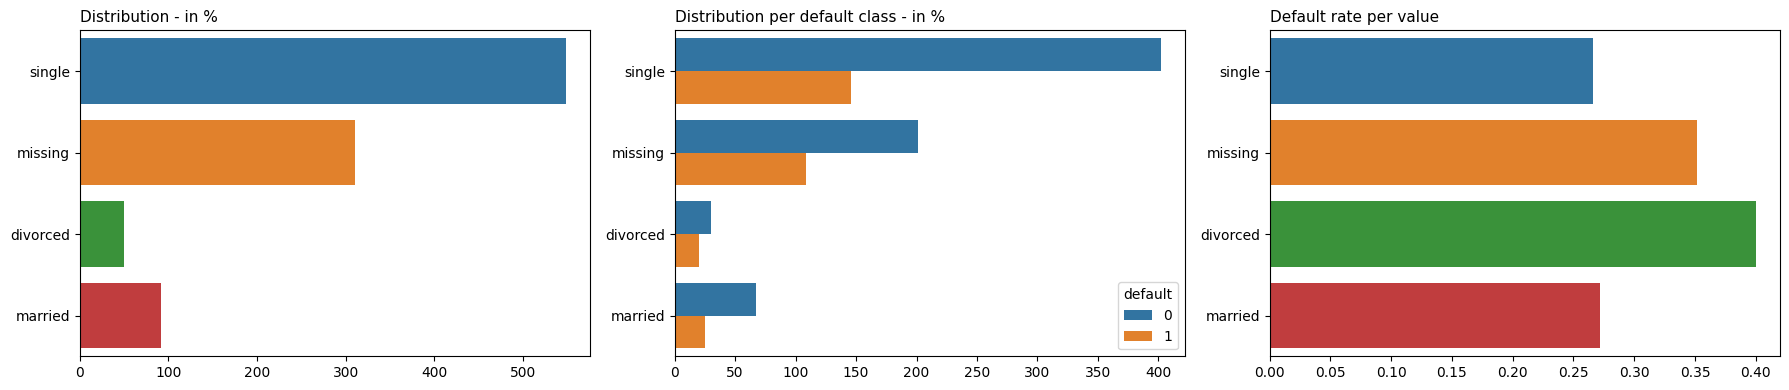

In [33]:
cat_feature_analysis(credit, 'personal_status')

- Distribution - Value is *single* for 55% of cases, *married* for 9% and *divorced* for 5%. 

- Risk trend - Risk is higher for divorced applicants. Single and married have pretty similar rates.

- Missing data - Data is missing for 31%. Default rate is higher than average for missing cases.

---

#### Other debtors

Presence of other debtor for the loan

Summary statistics: 
count     1000
unique       3
top       none
freq       907
Name: other_debtors, dtype: object

Percentage of missing data: 0.0%

Percentage of each discrete values: 
none            90.7
guarantor        5.2
co-applicant     4.1
Name: other_debtors, dtype: float64



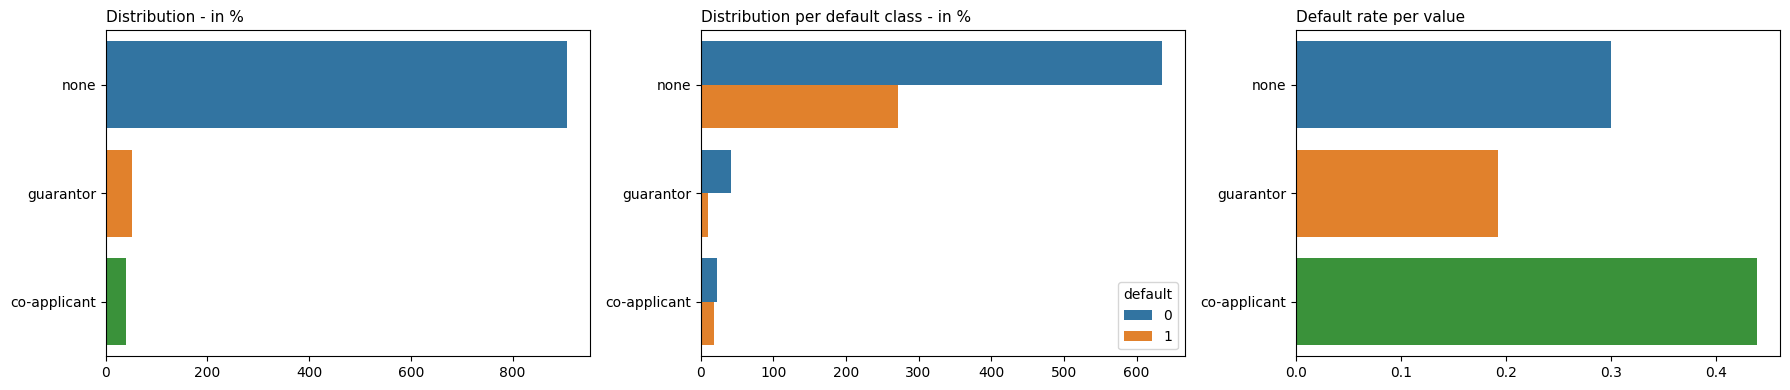

In [34]:
cat_feature_analysis(credit, 'other_debtors')

- Distribution - There is no other debtor in 91% of cases. 5% of cases have guarantor and 4% have co-applicant.

- Risk trend - Risk is significantly higher with co-applicant and lower with a guarantor.

- Missing data - None

---

#### Residence history

Present residence since

Summary statistics: 
count         870
unique         36
top       2 years
freq           43
Name: residence_history, dtype: object

Percentage of missing data: 13.0%

Default rate - missing data:  0.28

Default rate - non-missing:  0.3

Percentage of each discrete values: 
missing      13.0
2 years       4.3
8 months      3.8
1 years       3.7
3 years       3.6
0 months      3.4
4 years       3.3
9 months      2.9
1 months      2.8
10 years      2.7
3 months      2.6
22 years      2.5
11 months     2.5
13 years      2.5
2 months      2.4
18 years      2.4
6 months      2.4
23 years      2.3
24 years      2.3
5 months      2.2
11 years      2.2
20 years      2.1
8 years       2.1
14 years      2.0
10 months     2.0
5 years       2.0
4 months      2.0
9 years       1.9
17 years      1.9
15 years      1.9
16 years      1.9
7 years       1.9
12 years      1.9
21 years      1.8
7 months      1.8
19 years      1.5
6 years       1.5
Name: residence_history, dtype: float64



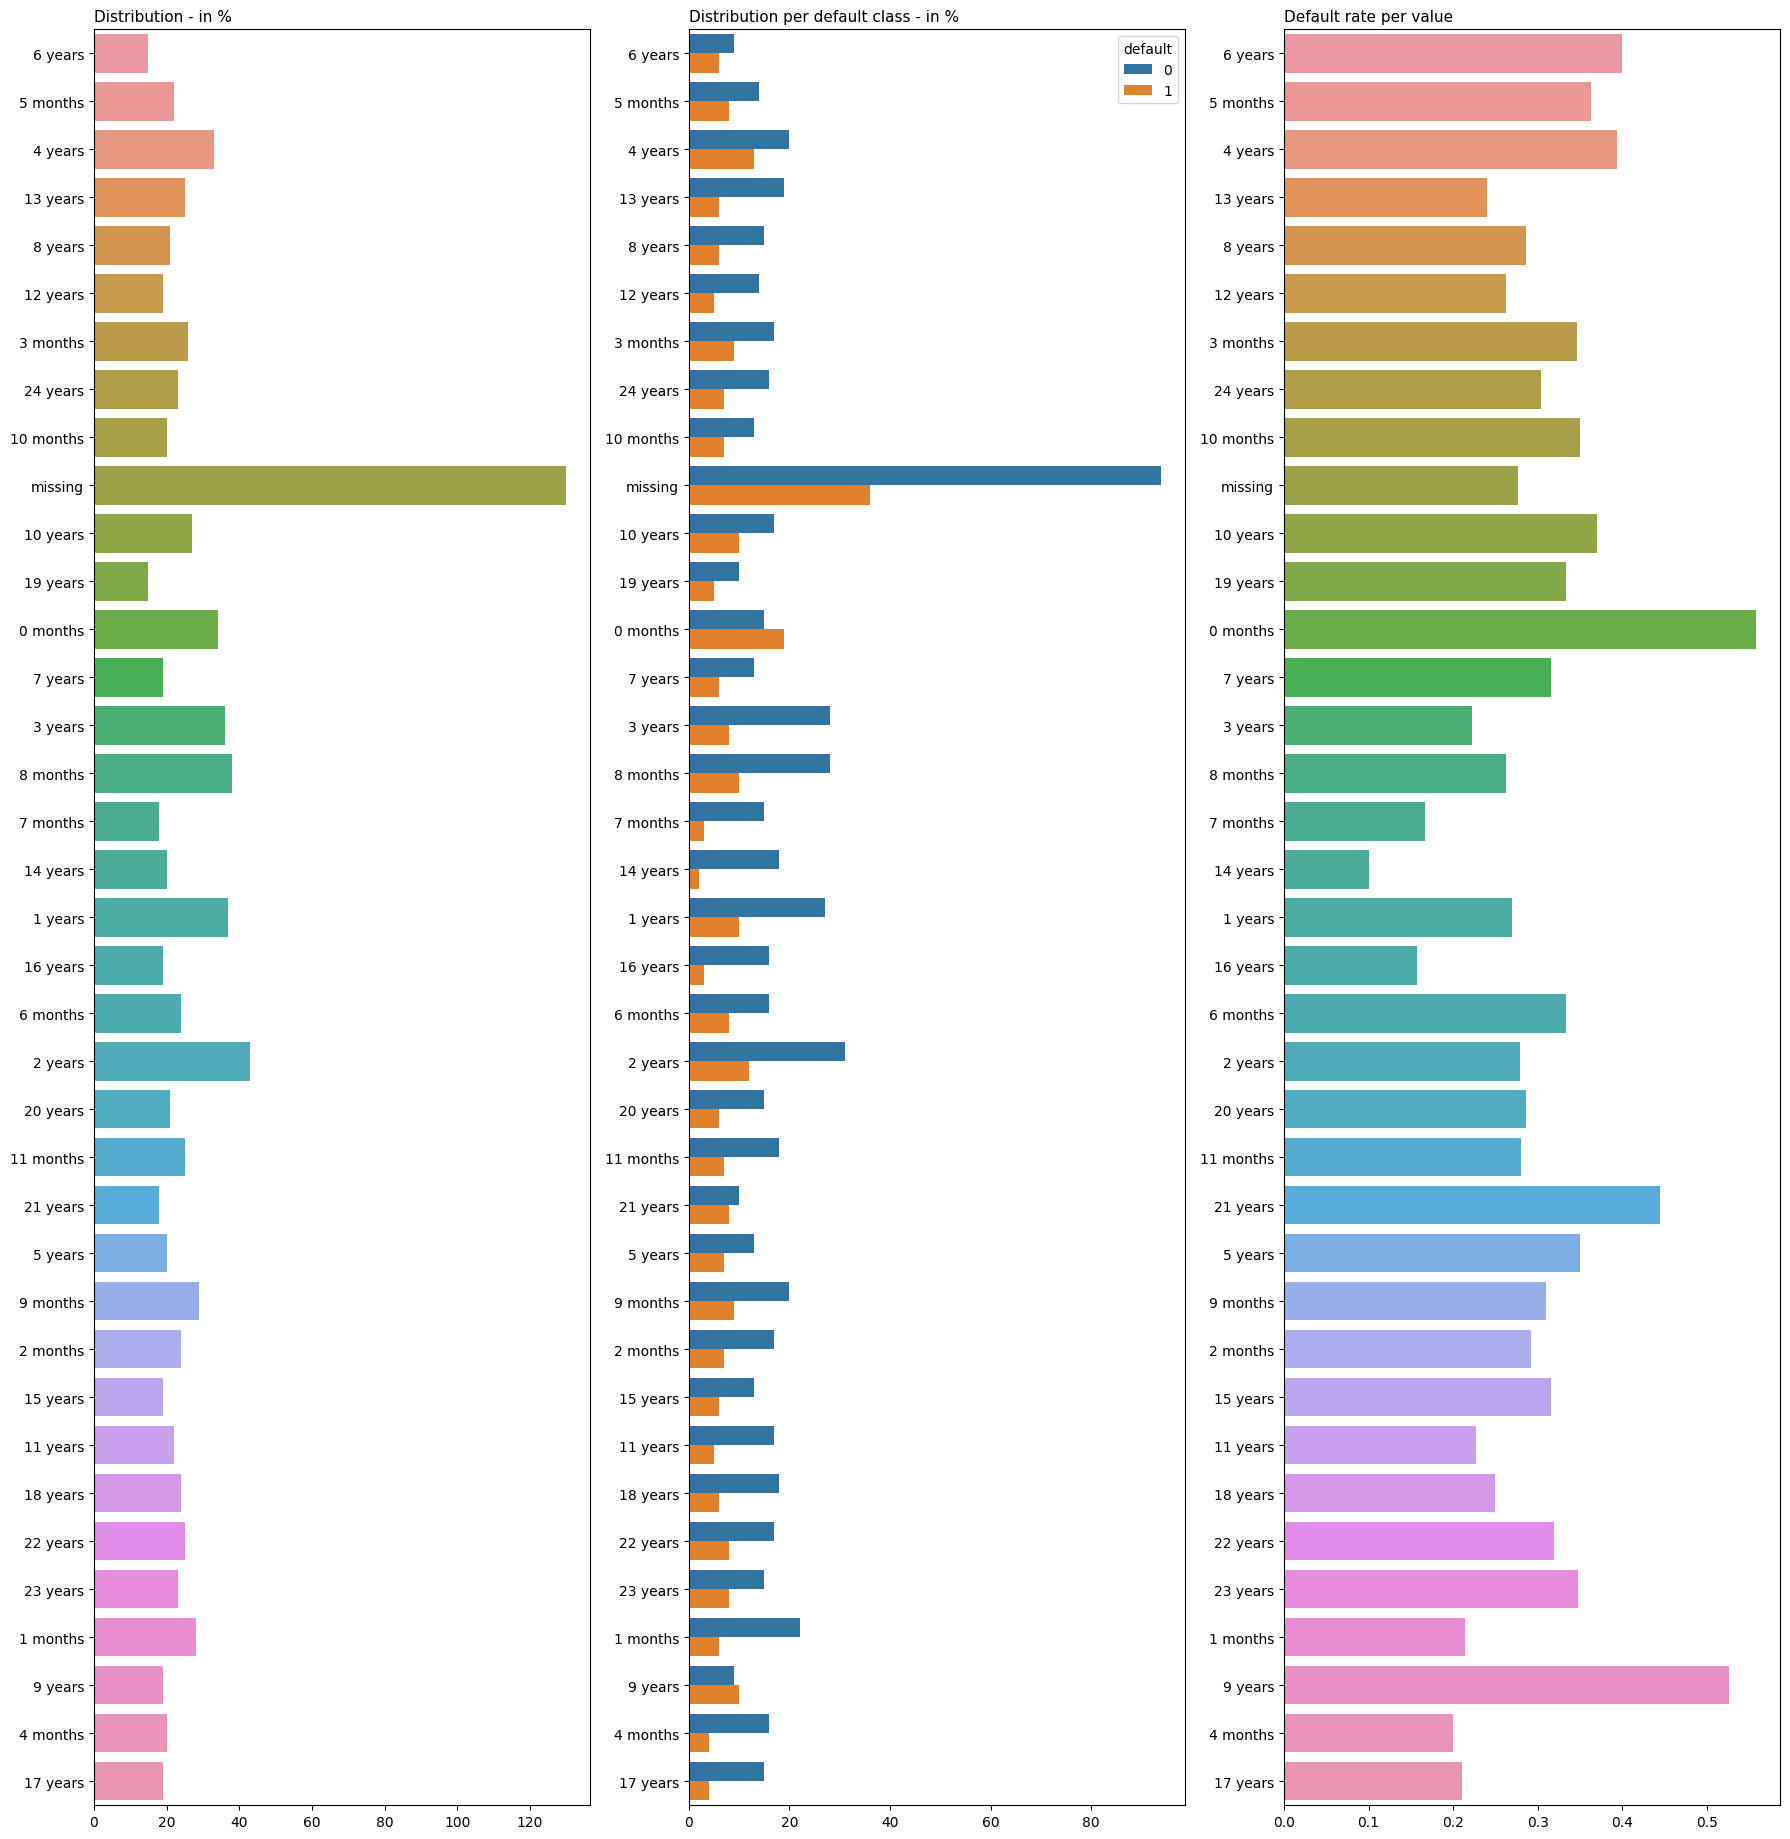

In [35]:
cat_feature_analysis(credit, 'residence_history')

- Distribution - Data is pretty evenly distributed between categories.

- Risk trend - This variable is hard to interpret as it is. There are too many categories. We either should reduce the categories or turn it into a numerical variables with years or months of employment.

- Missing data - Data is missing for 13% of cases. Default rate for missing is close to average.

---

#### Adjusted Residence History

Summary statistics: 
count    870.000000
mean      90.563218
std       94.917516
min        0.000000
25%        8.000000
50%       48.000000
75%      168.000000
max      288.000000
Name: residence_history, dtype: float64

Percentage of missing data: 13.0%

Default rate - missing data:  0.28

Default rate - non-missing:  0.3



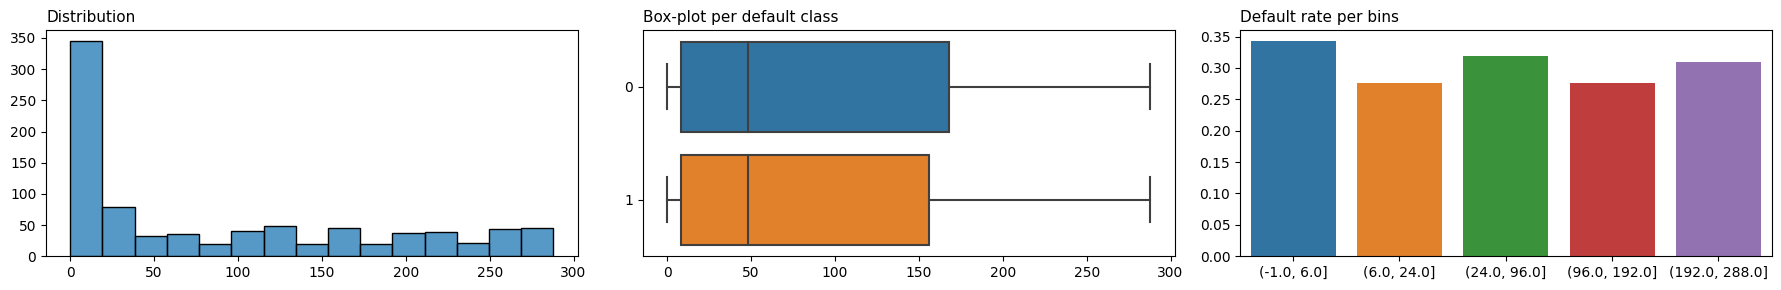

In [36]:
test = credit.copy()
test['residence_history'] = test.loc[test['residence_history'].notnull(), 'residence_history'].apply(lambda x : x.replace('months', '').strip() if 'months' in x else int(x.replace('years', '').strip())*12).astype(float)
num_feature_analysis(test, 'residence_history')

---

#### Property

Summary statistics: 
count      1000
unique        4
top       other
freq        332
Name: property, dtype: object

Percentage of missing data: 0.0%

Percentage of each discrete values: 
other                       33.2
real estate                 28.2
building society savings    23.2
unknown/none                15.4
Name: property, dtype: float64



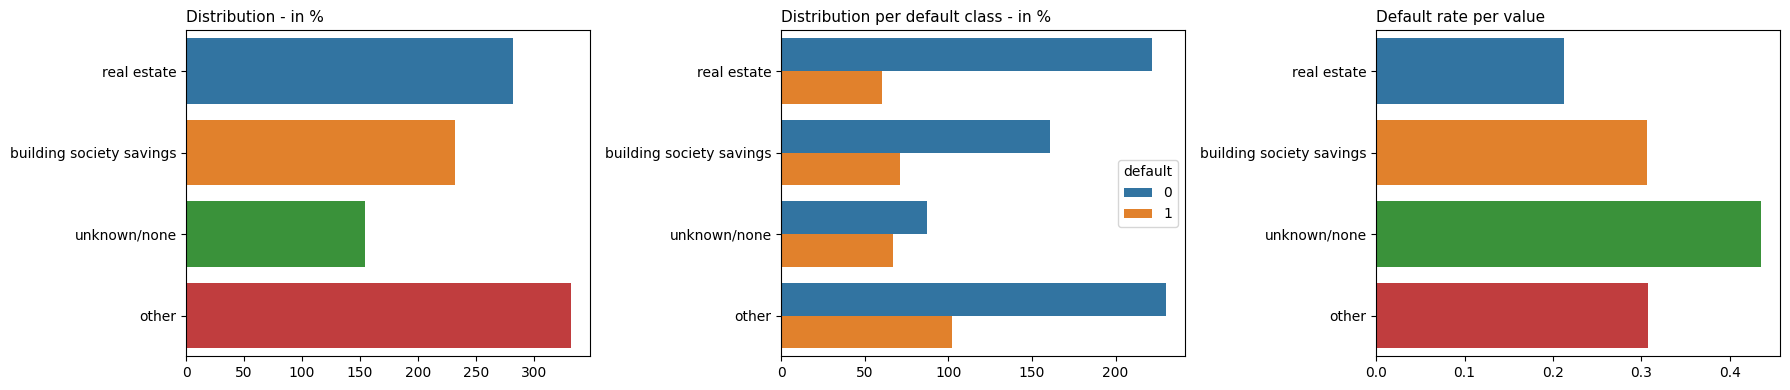

In [37]:
cat_feature_analysis(credit, 'property')

- Distribution - There are 4 categories with only two clearly interpretable (real estate and building society). The *other* category is the most frequent with 33% of cases followed by real estate and building 

- Risk trend - Real Estate owners have lower risk of defaults, while applicants with unknown property info have signficantly higher risk.

- Missing data - There is no missing data but there is an *unknown* category with 15% of cases.

- Suggested encoding: One hot encoding for real_estate and unknown

---

#### Installment plan

Other instalment plans.

Summary statistics: 
count     1000
unique       3
top       none
freq       814
Name: installment_plan, dtype: object

Percentage of missing data: 0.0%

Percentage of each discrete values: 
none      81.4
bank      13.9
stores     4.7
Name: installment_plan, dtype: float64



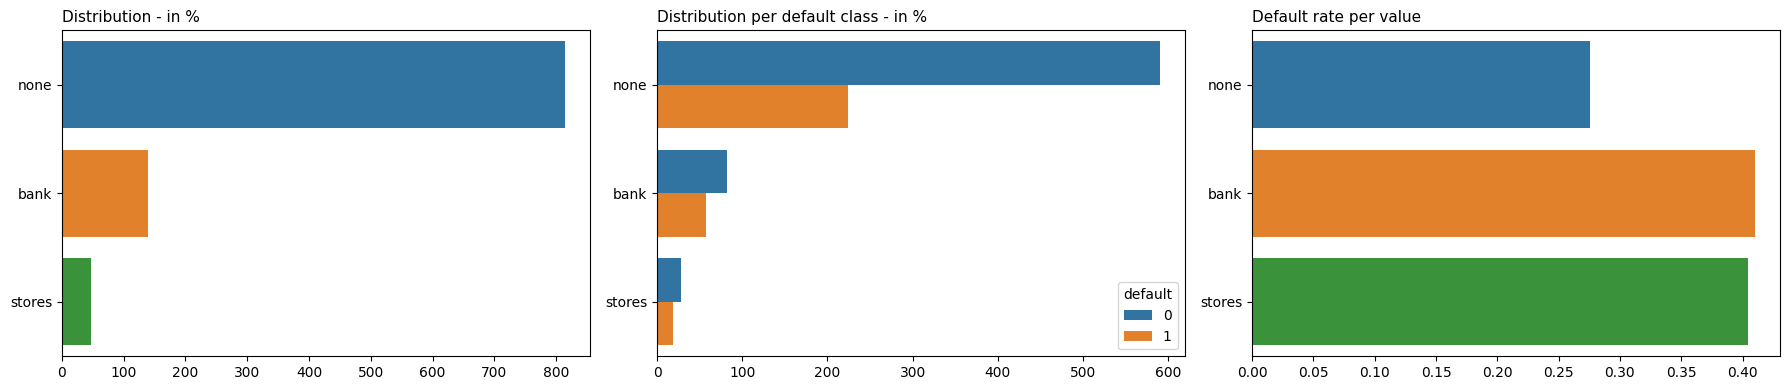

In [38]:
cat_feature_analysis(credit, 'installment_plan')

- Distribution - Most applicants have no other installment plan (81%), 14% have another bank installment plan and 5% have stores installment plan. 

- Risk trend - Risk is lower when there is no other installment plan. Applicants with bank or stores plan have similar rates.

- Missing data - None

- Suggested encoding: Binary indicator - Other installment plans ? 

---

#### Housing

Type of housing of the applicant.

Summary statistics: 
count     1000
unique       3
top        own
freq       713
Name: housing, dtype: object

Percentage of missing data: 0.0%

Percentage of each discrete values: 
own         71.3
rent        17.9
for free    10.8
Name: housing, dtype: float64



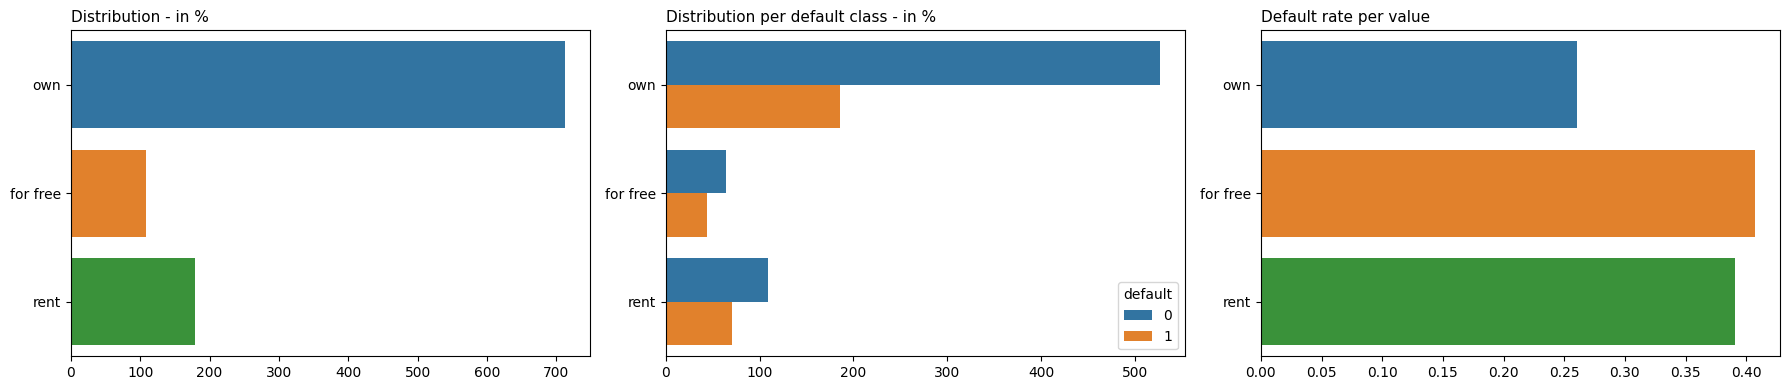

In [39]:
cat_feature_analysis(credit, 'housing')

- Distribution - Most applicants have their own property 71%, 18% are renting and 11% have free housing.

- Risk trend - Risk is significantly lower for owners and slightly higher for free housing.

- Missing data - None

- Suggested encoding: One Hot encoding or Label Encoding

---

#### Foreign worker

Is the applicant a foreign worker ?

Summary statistics: 
count     1000
unique       2
top        yes
freq       963
Name: foreign_worker, dtype: object

Percentage of missing data: 0.0%

Percentage of each discrete values: 
yes    96.3
no      3.7
Name: foreign_worker, dtype: float64



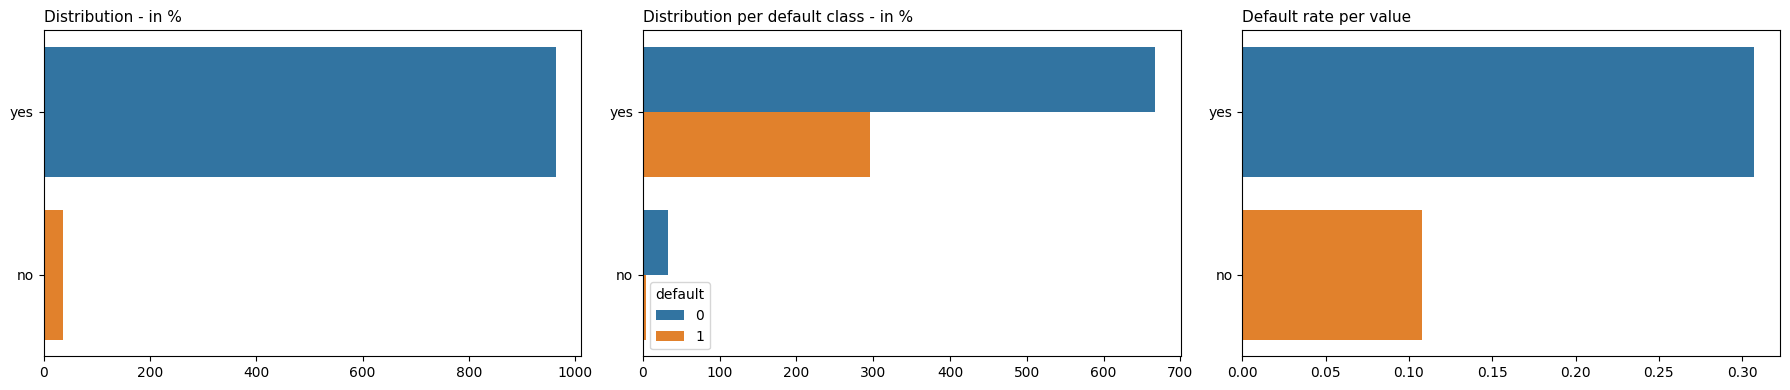

In [40]:
cat_feature_analysis(credit, 'foreign_worker')

- Distribution - Binary variable with 96% of Yes values. **Most applicants are foreigners**.

- Risk trend - Risk is significantly lower for non foreigners.

- Missing data - None

- Suggested encoding: One Hot encoding (is_foreign)

---

#### Job

Summary statistics: 
count                 1000
unique                   4
top       skilled employee
freq                   630
Name: job, dtype: object

Percentage of missing data: 0.0%

Percentage of each discrete values: 
skilled employee           63.0
unskilled resident         20.0
mangement self-employed    14.8
unemployed non-resident     2.2
Name: job, dtype: float64



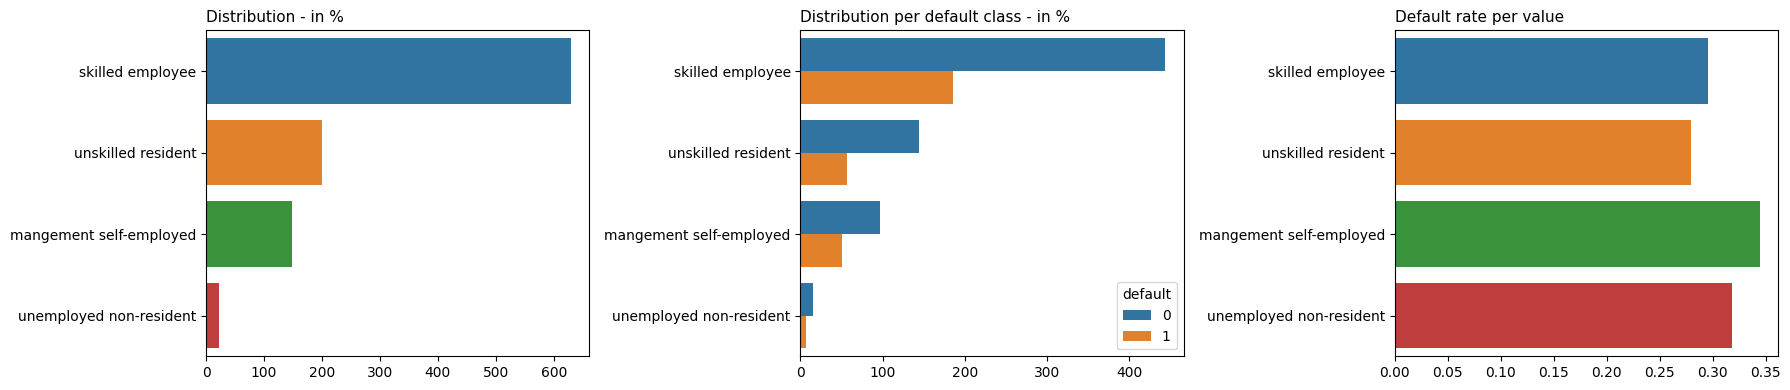

In [41]:
cat_feature_analysis(credit, 'job')

- Distribution - 4 categories of job skills/status mixed with residence status. 63% of applicants are skilled employees, 20% are unskilled resident worker, 15% are self-employed and 2% are unemployed non-resident.

- Risk trend - Risk is higher for self-employed and unemployed applicants. Unskilled resident have the lowest risk.

- Missing data - None

- Suggested encoding: OHE or label encoding.

---

#### Gender

Summary statistics: 
count     1000
unique       2
top       male
freq       690
Name: gender, dtype: object

Percentage of missing data: 0.0%

Percentage of each discrete values: 
male      69.0
female    31.0
Name: gender, dtype: float64



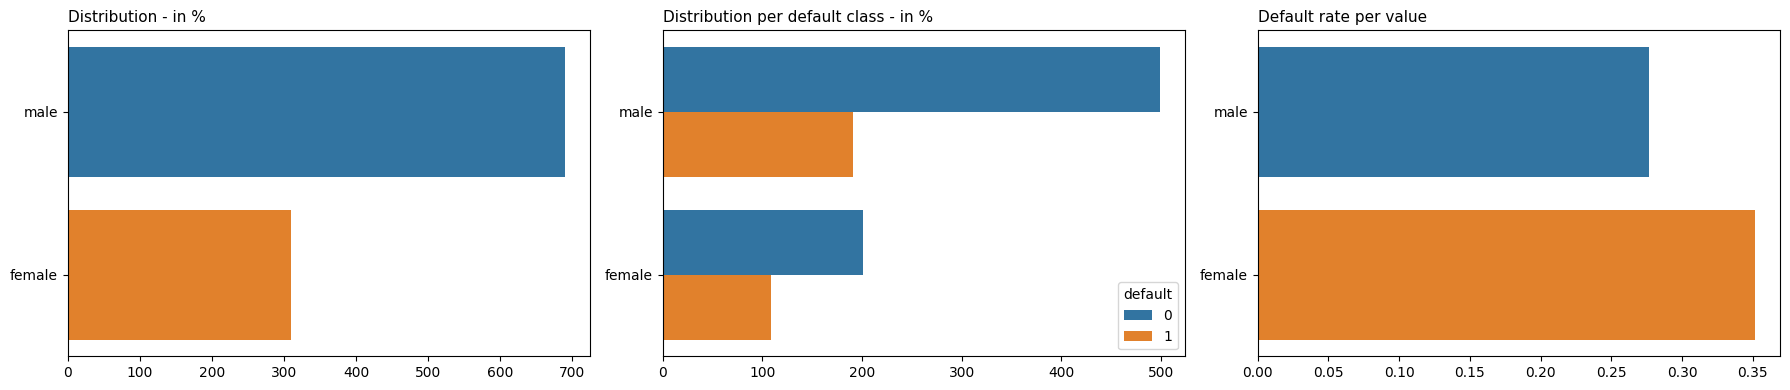

In [42]:
cat_feature_analysis(credit, 'gender')

- Distribution - 69% of applicants are male.

- Risk trend - Females have higher risk of default.

- Missing data - None

- Suggested encoding: one hot encoding.